**Image Classification using Quantum Convolution**

The algorithm presented here is intended as an example of quantum convolutional or quanvolutional neural network(QNN). QNNs add a transformational layer to the standard CNN architecture; these layers are made up of a group of random quantum filters which act on input images and produce their feature maps. Featurs produced by random quanvolutional circuits are expected to increase the accuracy of machine learning models for classification purposes.

We have used this hybrid quantum-classical implementation to process image datasets containing normal as well as cataract images, extract their features, train neural networks and finally use the trained network to classify test data as normal or cataract.




**Ref**: [1] Pennylane Demos/Quantum Machine Learning/Quanvolutional Neural Networks
     [2] Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits Henderson et al.(2019)
    
**Tools used** : Pennylane, Tensorflow

!pip install pennylane

!pip install matplotlib

Import required libraries

In [ ]:
import pennylane as qml
from pennylane import numpy as np

!pip install opencv-python

In [ ]:
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


In [ ]:
import os, glob, cv2
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects

Create a pandas dataframe containing the filenames of all normal and cataract images of the selected dataset (including filepaths) and their labels: 1 for cataract and 0 for normal

In [ ]:
SEED = 53
IMG_HEIGHT = 64
IMG_WIDTH = 64

# eye_diseases_classification dataset
IMG_ROOT = 'D:\Womanium2023\GlobalQuantumProject\Datasets\eye_diseases_classification\Proc\\' # change image directory as required

In [ ]:
IMG_DIR

['D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\normal',
 'D:\\Womanium2023\\GlobalQuantumProject\\Datasets\\eye_diseases_classification\\Proc\\cataract']

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [ ]:
df = pd.DataFrame(0,
                  columns=['paths',
                           'cataract'],
                  index=range(2500))

filepaths = glob.glob(IMG_ROOT + '*/*')

for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df.iloc[i, 0] = filepath[0] + '/' + filepath[1]

    if filepath[0] == IMG_DIR[0]:    # normal
            df.iloc[i, 1] = 0
    elif filepath[0] == IMG_DIR[1]:  # cataract
            df.iloc[i, 1] = 1

In [ ]:
print('Number of normal and cataract images')
print(df['cataract'].value_counts())

Number of normal and cataract images
cataract
0    1562
1     938
Name: count, dtype: int64


In [ ]:
df = df[df.paths !=0] # remove rows with no data


Split the data into training, validation and test sets. Assemble each set of images into array of arrays and normalise the gray pixel values

In [ ]:
train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=df['cataract'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['cataract'])

In [ ]:
from tqdm import tqdm

def create_datasets(df):
    imgs = []

    for path in tqdm(df['paths']):
        #print(path)
        img = cv2.imread(path,0)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        imgs.append(img)

    imgs = np.array(imgs, dtype='float32')

    labels = df.cataract
    return imgs, labels


train_imgs, train_labels = create_datasets(train_df)
val_imgs, val_labels = create_datasets(val_df)
test_imgs, test_labels = create_datasets(test_df)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0

100%|███████████████████████████████████████████████████████████████████████████████| 403/403 [00:01<00:00, 353.49it/s]


In [ ]:
np.shape(train_imgs[0])

(64, 64)

Prepare the arrays for quantum convolution.

In [ ]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "eyeQCNN1/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
# Reduce dataset size
train_images = train_imgs[:n_train]
train_labels = train_labels[:n_train]
test_images = test_imgs[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
#train_images = train_images / 255
#test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [ ]:
np.shape(train_images[0])

(64, 64, 1)

Initialize a PennyLane default.qubit device, simulating a system of 4 qubits. The associated qnode represents the quantum circuit consisting of:
an embedding layer of local Ry rotations (with angles scaled by a factor of π), a random circuit of n_layers and a final measurement in the computational basis, estimating 4 expectation values.



In [ ]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Define the quantum convolution scheme : divide the image into squares of 2 x 2 pixels, process each square with the quantum circuit and map the 4 expectation values into 4 different channels of a single output pixel.

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((32, 32, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 64, 2):
        for k in range(0, 64, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Apply quantum convolution on the images and save the pre-processed images for re-use.

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
#q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


In [ ]:
train_labels=np.array(train_labels)
test_labels = np.array(test_labels)

Visualize the effect of the quanvolution layer on a batch of 4 sample images. Below each input image, the 4 output channels generated by the quantum convolution are visualized in grayscale. We can see that though local distortion is introduced by the quantum kernel, the global shape of the image is preserved as expected for a convolution layer

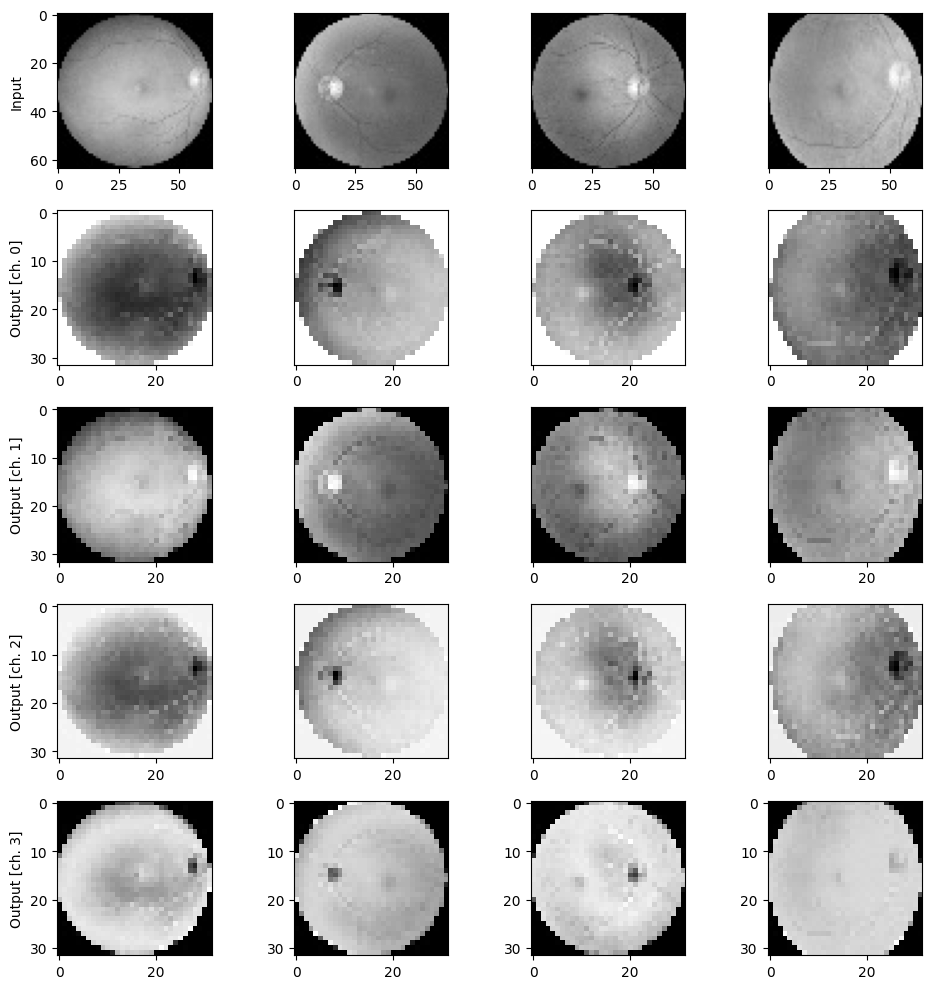

In [ ]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

As a hybrid Quantum-classical model, the output features of the quanvolution layer are fed into a simple classical neural network model and trained to classify a test image as either normal or cataract.

In [ ]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        #keras.layers.Dense(5,activation='relu'),
        keras.layers.Dense(1,activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss="binary_crossentropy",#loss="sparse_categorical_crossentropy
        metrics=["accuracy"],
    )
    return model

In [ ]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 0.6947 - accuracy: 0.6200 - val_loss: 0.7917 - val_accuracy: 0.6333 - 388ms/epoch - 30ms/step
Epoch 2/30
13/13 - 0s - loss: 0.4689 - accuracy: 0.7800 - val_loss: 0.9816 - val_accuracy: 0.5667 - 32ms/epoch - 2ms/step
Epoch 3/30
13/13 - 0s - loss: 0.4546 - accuracy: 0.7800 - val_loss: 0.6398 - val_accuracy: 0.6667 - 31ms/epoch - 2ms/step
Epoch 4/30
13/13 - 0s - loss: 0.3248 - accuracy: 0.8800 - val_loss: 1.0102 - val_accuracy: 0.5667 - 31ms/epoch - 2ms/step
Epoch 5/30
13/13 - 0s - loss: 0.3573 - accuracy: 0.8800 - val_loss: 1.2415 - val_accuracy: 0.5000 - 33ms/epoch - 3ms/step
Epoch 6/30
13/13 - 0s - loss: 0.3299 - accuracy: 0.8800 - val_loss: 0.8512 - val_accuracy: 0.6000 - 31ms/epoch - 2ms/step
Epoch 7/30
13/13 - 0s - loss: 0.3431 - accuracy: 0.8800 - val_loss: 1.0150 - val_accuracy: 0.6000 - 31ms/epoch - 2ms/step
Epoch 8/30
13/13 - 0s - loss: 0.2730 - accuracy: 0.9000 - val_loss: 1.0317 - val_accuracy: 0.5333 - 32ms/epoch - 2ms/step
Epoch 9/30
13/13 - 0s 

For the purpose of comparison , another instance of the classical neural network is trained with the classical dta , i.e. without using the quantum pre-processed data

In [ ]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - loss: 0.7415 - accuracy: 0.5400 - val_loss: 0.9186 - val_accuracy: 0.5333 - 386ms/epoch - 30ms/step
Epoch 2/30
13/13 - 0s - loss: 0.5750 - accuracy: 0.7400 - val_loss: 0.6946 - val_accuracy: 0.5333 - 32ms/epoch - 2ms/step
Epoch 3/30
13/13 - 0s - loss: 0.8422 - accuracy: 0.5200 - val_loss: 1.4545 - val_accuracy: 0.5333 - 31ms/epoch - 2ms/step
Epoch 4/30
13/13 - 0s - loss: 0.6751 - accuracy: 0.7400 - val_loss: 0.7423 - val_accuracy: 0.5333 - 32ms/epoch - 2ms/step
Epoch 5/30
13/13 - 0s - loss: 0.6860 - accuracy: 0.6400 - val_loss: 0.9690 - val_accuracy: 0.5667 - 32ms/epoch - 2ms/step
Epoch 6/30
13/13 - 0s - loss: 0.4917 - accuracy: 0.8200 - val_loss: 0.8741 - val_accuracy: 0.5000 - 32ms/epoch - 2ms/step
Epoch 7/30
13/13 - 0s - loss: 0.4952 - accuracy: 0.8000 - val_loss: 0.8319 - val_accuracy: 0.5000 - 31ms/epoch - 2ms/step
Epoch 8/30
13/13 - 0s - loss: 0.4579 - accuracy: 0.8200 - val_loss: 0.9658 - val_accuracy: 0.5333 - 31ms/epoch - 2ms/step
Epoch 9/30
13/13 - 0s 

C:\Users\User\AppData\Local\Temp\ipykernel_3380\925943430.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


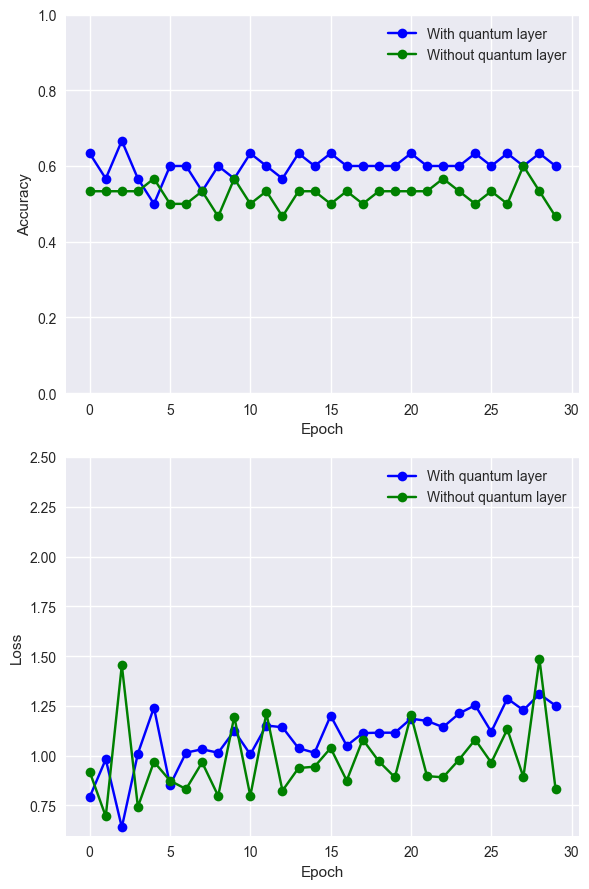

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

This program demonstrates the use of the software tools for designing and executing the hybrid algorithm.  Further network tuning is to be done to improve the validation accuracy